# PAM MI Optimization for Peak power contrained AWGN channel

This Jupyter notebook implements the Blahut-Arimoto algorithm for computing the optimal symbols probabilities for a PAM constellation to maximize the mutual information (MI) for a peak-power constrained AWGN channel. It computes the MI by leveraging Gauss-Hermite quadrature. MI of the optimized constellations are compared with that of uniform distribution and known upper-bounds from literature.

A. Thangaraj, G. Kramer, and G. Böcherer, “Capacity Bounds for Discrete-Time, Amplitude-Constrained,
Additive White Gaussian Noise Channels,” IEEE Transactions on Information Theory, vol. 63, no. 7, pp.
4172–4182, Jul. 2017.

**Note**: Ensure the required Python libraries (NumPy, SciPy, and Matplotlib) are installed.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import roots_hermite
from scipy.optimize import minimize
from numpy import log2, sqrt, pi, exp
from scipy.integrate import quad
import os, json


## Utility Functions

In [11]:
def db2pow(db):
    return 10 ** (db / 10)

def MI_fun(x, sigma, p, nodes, weights):
    p = np.array(p).reshape(1, -1)
    ys = sqrt(2) * sigma * nodes[:, None] + x
    Gs = np.exp(-0.5 * ((ys[..., None] - x)**2) / (sigma**2)) / (sqrt(2*pi) * sigma)
    Gsx = np.stack([Gs[:, i, i] for i in range(len(x))], axis=1)
    hs = np.log2(p) + np.log2(Gsx) - np.log2(np.sum(p * Gs, axis=2))
    MI = -np.sum(p * np.log2(p)) + np.sum(p * (weights @ hs) / sqrt(pi))
    return MI


In [12]:
def opt_fun(x, sigma, max_iter, nodes, weights):
    tol = 1e-8
    p = np.ones(len(x)) / len(x)
    ys = sqrt(2) * sigma * nodes[:, None] + x
    Gs = np.exp(-0.5 * ((ys[..., None] - x)**2) / (sigma**2)) / (sqrt(2*pi) * sigma)
    Gsx = np.stack([Gs[:, i, i] for i in range(len(x))], axis=1)
    log2Gsx = np.log2(Gsx)
    prev_MI = 0

    for t in range(max_iter):
        hs = np.log2(p) + log2Gsx - np.log2(np.sum(p * Gs, axis=2))
        T = (weights @ hs) / sqrt(pi)
        r = 2**T
        MI = np.log2(np.sum(r))
        p = r / np.sum(r)
        if abs(MI - prev_MI) < tol:
            break
        prev_MI = MI
    return MI, p

# Q-function implementation using numerical integration
def Q(X):
    # Vectorized version
    return np.array([
        quad(lambda t: np.exp(-t**2 / 2), x, np.inf)[0] / np.sqrt(2 * np.pi) 
        for x in np.atleast_1d(X)
    ])

# Binary entropy function
def He(x):
    x = np.clip(x, 1e-10, 1 - 1e-10)  # Avoid log(0)
    return -x * np.log2(x) - (1 - x) * np.log2(1 - x)

# Beta function as defined
def Beta(P):
    return 0.5 - Q(2 * np.sqrt(P))




## Main Execution Loop

In [13]:
M = 8 # Number of constellation points
x = np.linspace(-(M-1), M-1, M)
x = x / np.max(np.abs(x))  # Unit peak
nodes, weights = roots_hermite(40)
P_peak = 1
SNR_dB_list = np.arange(-5, 31)
MI_BAs = []
p_BAs = []
MI_UNs = []

for SNR_dB in SNR_dB_list:
    SNR_lin = db2pow(SNR_dB)
    sigma = sqrt(P_peak / SNR_lin)
    p_uniform = np.ones(M) / M
    MI_BA, p_BA = opt_fun(x, sigma, 10000, nodes, weights)
    MI_UN = MI_fun(x, sigma, p_uniform, nodes, weights)
    MI_BAs.append(MI_BA)
    p_BAs.append(p_BA)
    MI_UNs.append(MI_UN)
    print(f"SNR {SNR_dB} dB: MI_BA = {MI_BA:.4f}, MI_UN = {MI_UN:.4f}")


# Input: SNR values in dB
P = db2pow(SNR_dB_list)

# McKellips' bound
bound_mckellips = np.log2(1 + 2 * np.sqrt(P) / np.sqrt(2 * np.pi * np.exp(1)))

# Shannon capacity bound
bound_shannon = 0.5 * np.log2(1 + P)

# Refined bound
beta_vals = Beta(P)
bound_refined = beta_vals * np.log2(np.sqrt(2 * P / (np.pi * np.exp(1)))) + He(beta_vals)




SNR -5 dB: MI_BA = 0.1977, MI_UN = 0.0917
SNR -4 dB: MI_BA = 0.2407, MI_UN = 0.1136
SNR -3 dB: MI_BA = 0.2910, MI_UN = 0.1403
SNR -2 dB: MI_BA = 0.3489, MI_UN = 0.1725
SNR -1 dB: MI_BA = 0.4141, MI_UN = 0.2111
SNR 0 dB: MI_BA = 0.4859, MI_UN = 0.2569
SNR 1 dB: MI_BA = 0.5628, MI_UN = 0.3104
SNR 2 dB: MI_BA = 0.6421, MI_UN = 0.3723
SNR 3 dB: MI_BA = 0.7207, MI_UN = 0.4429
SNR 4 dB: MI_BA = 0.7944, MI_UN = 0.5222
SNR 5 dB: MI_BA = 0.8623, MI_UN = 0.6100
SNR 6 dB: MI_BA = 0.9387, MI_UN = 0.7057
SNR 7 dB: MI_BA = 1.0252, MI_UN = 0.8088
SNR 8 dB: MI_BA = 1.1194, MI_UN = 0.9184
SNR 9 dB: MI_BA = 1.2179, MI_UN = 1.0339
SNR 10 dB: MI_BA = 1.3161, MI_UN = 1.1546
SNR 11 dB: MI_BA = 1.4184, MI_UN = 1.2799
SNR 12 dB: MI_BA = 1.5286, MI_UN = 1.4093
SNR 13 dB: MI_BA = 1.6432, MI_UN = 1.5422
SNR 14 dB: MI_BA = 1.7581, MI_UN = 1.6781
SNR 15 dB: MI_BA = 1.8749, MI_UN = 1.8168
SNR 16 dB: MI_BA = 1.9984, MI_UN = 1.9576
SNR 17 dB: MI_BA = 2.1277, MI_UN = 2.1002
SNR 18 dB: MI_BA = 2.2613, MI_UN = 2.2436
SN

In [14]:

MI_LWs = np.zeros(len(SNR_dB_list))
p_LWs = np.zeros((len(SNR_dB_list),8))
for i,SNR_dB in enumerate(SNR_dB_list):
    run_name = f'learning_weights_AWGN_PPC_MI_OPT_PS8PAM_SNR_dB_{SNR_dB:0.1f}'
    save_filename = f'{os.getcwd()}/AWGN_PPC/{run_name}.json'
    # Opening JSON file
    with open(save_filename, 'r') as openfile: 
        # Reading from json file
        json_object = json.load(openfile)

    MI_LWs[i] = json_object["epoch-299"]['Validation_MI']
    p_LWs[i,:] = json_object["epoch-299"]['Symbol probabilities']

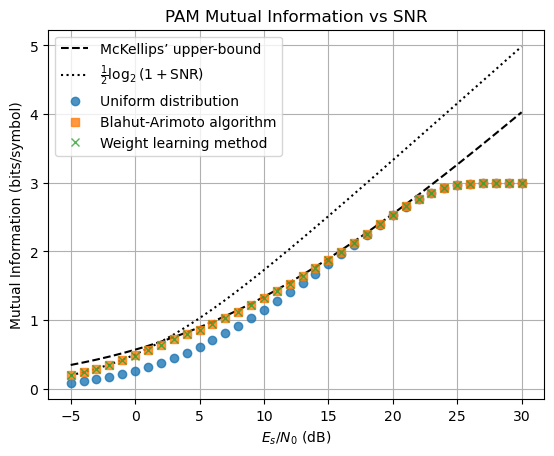

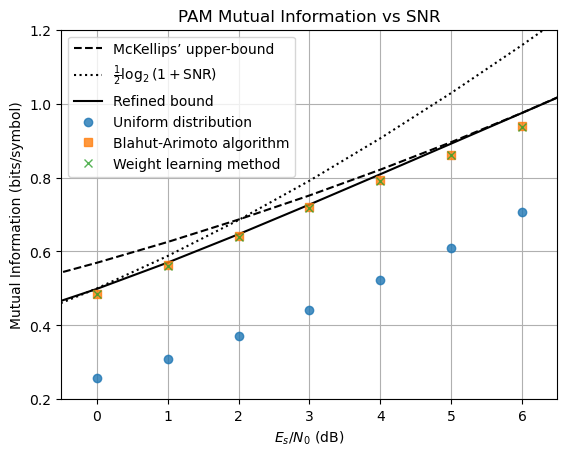

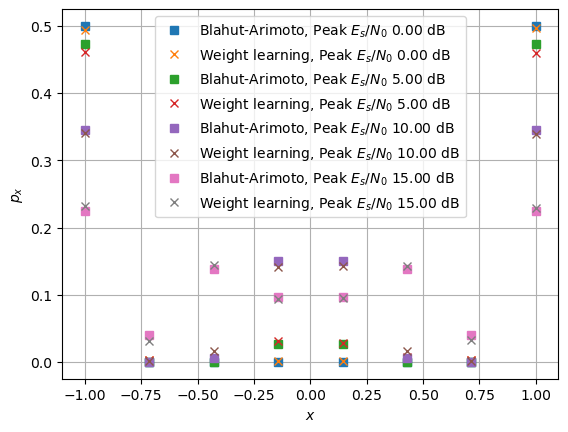

In [15]:

# Plotting results
plt.plot(SNR_dB_list, bound_mckellips,'--k', label="McKellips’ upper-bound")
plt.plot(SNR_dB_list, bound_shannon,':k', label=r"$\frac{1}{2}\log_2(1+\mathrm{SNR})$")
plt.plot(SNR_dB_list, MI_UNs, 'o', label='Uniform distribution',alpha=0.8)
plt.plot(SNR_dB_list, MI_BAs, 's', label='Blahut-Arimoto algorithm',alpha=0.8)
plt.plot(SNR_dB_list, MI_LWs, 'x', label='Weight learning method',alpha=0.8)


plt.xlabel('$E_s/N_0$ (dB)')
plt.ylabel('Mutual Information (bits/symbol)')
plt.grid(True)
plt.title('PAM Mutual Information vs SNR')
plt.legend()
plt.savefig("plots/AWGN_PPC_PAM8_MI.png",dpi=600,bbox_inches="tight")
plt.show()


# Plotting results
plt.plot(SNR_dB_list, bound_mckellips,'--k', label="McKellips’ upper-bound")
plt.plot(SNR_dB_list, bound_shannon,':k', label=r"$\frac{1}{2}\log_2(1+\mathrm{SNR})$")
plt.plot(SNR_dB_list, bound_refined,'-k', label="Refined bound")
plt.plot(SNR_dB_list, MI_UNs, 'o', label='Uniform distribution',alpha=0.8)
plt.plot(SNR_dB_list, MI_BAs, 's', label='Blahut-Arimoto algorithm',alpha=0.8)
plt.plot(SNR_dB_list, MI_LWs, 'x', label='Weight learning method',alpha=0.8)
plt.xlabel('$E_s/N_0$ (dB)')
plt.ylabel('Mutual Information (bits/symbol)')
plt.grid(True)
plt.title('PAM Mutual Information vs SNR')

plt.xlim([-0.5,6.5])
plt.ylim([0.2,1.2])
plt.legend()
plt.savefig("plots/AWGN_PPC_PAM8_MI_refined.png",dpi=600,bbox_inches="tight")
plt.show()


plot_SNR_dB = [0,5,10,15]
for i,SNR_dB in enumerate(SNR_dB_list):
    if SNR_dB in plot_SNR_dB:
        plt.plot(x,p_BAs[i],'s',label=f'Blahut-Arimoto, Peak $E_s/N_0$ {SNR_dB:0.2f} dB')
        plt.plot(x,p_LWs[i],'x',label=f'Weight learning, Peak $E_s/N_0$ {SNR_dB:0.2f} dB')

plt.xlabel("$x$")
plt.ylabel("$p_x$")
plt.grid()
plt.legend()
plt.savefig("plots/AWGN_PPC_PAM8_px.png",dpi=600,bbox_inches="tight")
plt.show()


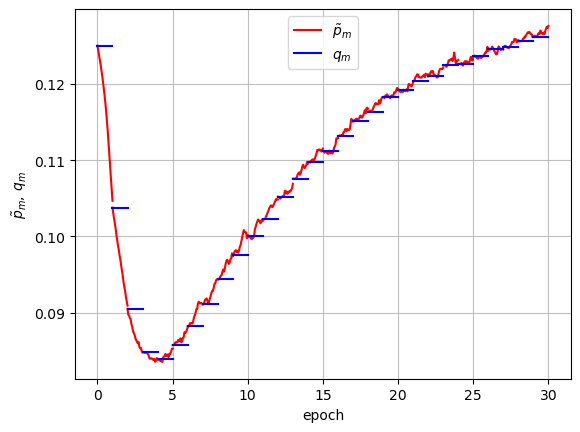

In [16]:

run_name = 'learning_weights_AWGN_PPC_MI_OPT_PS8PAM_SNR_dB_10.0'
save_filename = f'{os.getcwd()}/AWGN_PPC/{run_name}.json'
# Opening JSON file
with open(save_filename, 'r') as openfile: 
    # Reading from json file
    json_object = json.load(openfile)

sym_idx = 4
for epoch in range(30):
    p_LWs = np.zeros(20)
    for batch in range(20):
        p_LWs[batch] = json_object[f"epoch-{epoch}"][f'batch-{batch}']['Symbol probabilities'][sym_idx]
    if epoch == 0:
        plt.plot(epoch+np.linspace(0,1,20),p_LWs,'r',label=r'$\tilde{p}_m$')
        plt.plot(epoch+np.linspace(0,1,20),np.ones(20)*json_object[f"epoch-{epoch}"]['q_symbols'][sym_idx],'b',label=r'$q_m$')
    else:
        plt.plot(epoch+np.linspace(0,1,20),p_LWs,'r')
        plt.plot(epoch+np.linspace(0,1,20),np.ones(20)*json_object[f"epoch-{epoch}"]['q_symbols'][sym_idx],'b')

plt.xlabel('epoch')
plt.ylabel(r'$\tilde{p}_m,\,q_m$')
plt.legend(loc="upper center")
plt.grid(alpha=0.8)
plt.savefig("plots/weight_learning_visualized.png",dpi=600,bbox_inches="tight")
plt.show()